# Importing the Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install pycaret

In [ ]:
!pip install pmdarima

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import plotly.express as px
from pmdarima import auto_arima
from statsmodels.tsa.seasonal import STL


In [ ]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from pycaret.time_series import TSForecastingExperiment

# Importing the Data

In [ ]:
# Replace 'path_to_your_csv_file' with the actual path to your CSV file
file_path = '/content/drive/MyDrive/Trails/NVDA 1.csv'

# Load the dataset
data = pd.read_csv(file_path)

# Display the first few rows of the dataset to check if it's loaded correctly
print(data.head())


         Date     Open     High      Low    Close  Adj Close     Volume
0  2012-11-20  0.28950  0.29075  0.28425  0.28725   0.265173  336976000
1  2012-11-21  0.28725  0.29625  0.28700  0.29550   0.272789  422312000
2  2012-11-23  0.29675  0.30100  0.29525  0.29750   0.274636  276932000
3  2012-11-26  0.29800  0.30350  0.29750  0.30275   0.279482  364600000
4  2012-11-27  0.30150  0.30850  0.29900  0.30400   0.280636  451404000


# About Dataset

In [ ]:
# Display basic information about the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2915 entries, 0 to 2914
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2915 non-null   object 
 1   Open       2915 non-null   float64
 2   High       2915 non-null   float64
 3   Low        2915 non-null   float64
 4   Close      2915 non-null   float64
 5   Adj Close  2915 non-null   float64
 6   Volume     2915 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 159.5+ KB


In [ ]:
# Display summary statistics of the dataset
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2.915000e+03
mean,12.203867,12.424575,11.971037,12.212220,12.184745,4.499863e+08
std,19.324402,19.672322,18.933069,19.333715,19.338275,2.473682e+08
min,0.287250,0.290750,0.284250,0.287250,0.265173,4.564400e+07
25%,0.646500,0.657000,0.633500,0.647125,0.630227,2.912780e+08
50%,4.743000,4.817500,4.659750,4.738500,4.698981,3.978650e+08
75%,15.091000,15.345750,14.817875,15.112000,15.095000,5.422780e+08
max,139.800003,140.759995,130.690002,135.580002,135.580002,3.692928e+09


In [ ]:
# Check for missing value
data.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

## Slicing the Data

In [ ]:
# Select only the 'Date' and 'Adj Close' columns
nvidia_data = data[['Date', 'Adj Close']].copy()

# Parse the dates and set the 'Date' column as the index
nvidia_data['Date'] = pd.to_datetime(nvidia_data['Date'])
nvidia_data.set_index('Date', inplace=True)

# Display the first few rows to verify changes
print(nvidia_data.head())

            Adj Close
Date                 
2012-11-20   0.265173
2012-11-21   0.272789
2012-11-23   0.274636
2012-11-26   0.279482
2012-11-27   0.280636


# EDA

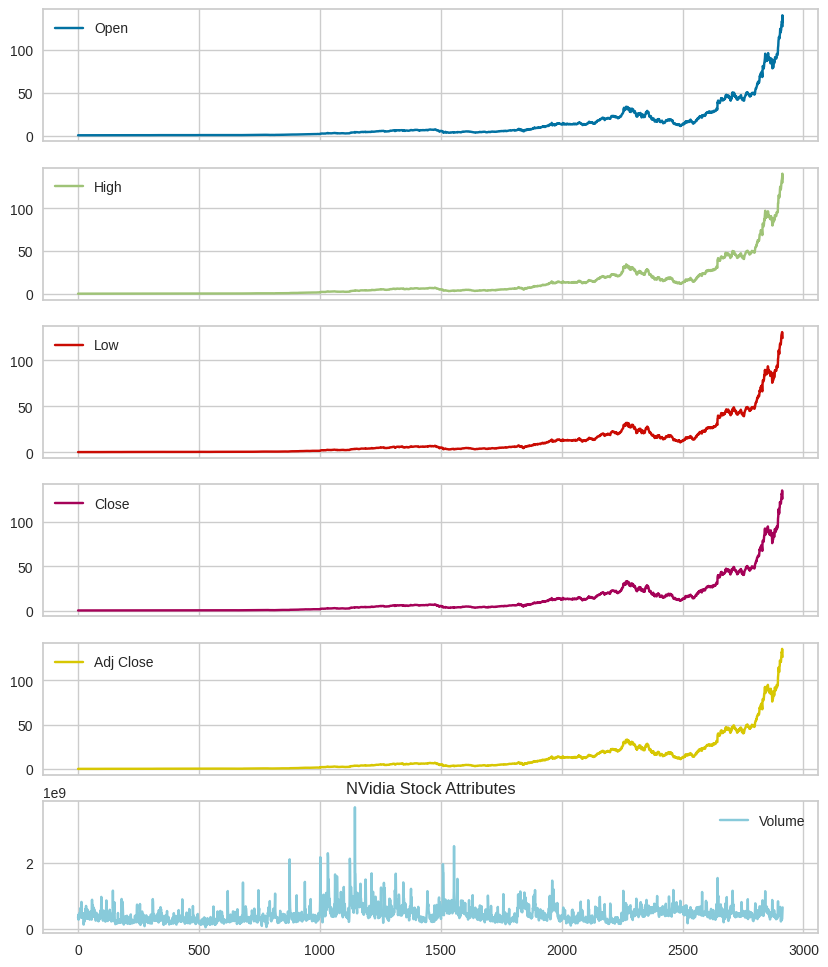

In [ ]:
data.plot(subplots = True, figsize = (10,12))
plt.title('NVidia Stock Attributes')
plt.show()

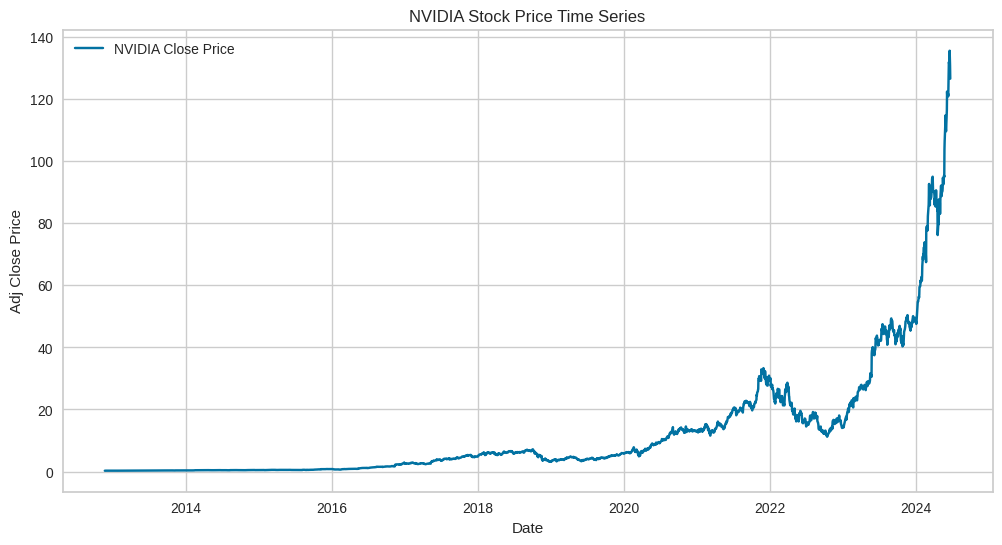

In [ ]:
# Plotting the time series data
plt.figure(figsize=(12, 6))
plt.plot( nvidia_data['Adj Close'], label='NVIDIA Close Price')
plt.title('NVIDIA Stock Price Time Series')
plt.xlabel('Date')
plt.ylabel('Adj Close Price')
plt.legend()
plt.show()


In [ ]:
# Create an interactive plot using Plotly
fig = px.line(nvidia_data, x=nvidia_data.index, y='Adj Close', title='NVIDIA Stock Price')

# Customize the layout
fig.update_layout(
    xaxis_title='Date',
    yaxis_title='Adj Close Price',
    legend_title_text='Stock Price',
    template='ggplot2'
)

# Show the plot
fig.show()

## Decomposition

In [ ]:
# Set the period for STL decomposition (adjust based on your data)
period = 252  # For yearly seasonality in daily stock data

# Perform STL decomposition
stl = STL(nvidia_data['Adj Close'], period=period)
result = stl.fit()

# Extract the components
trend = result.trend
seasonal = result.seasonal
residual = result.resid
season_adjust = trend + residual

# Create a DataFrame to hold the components and other relevant columns
components_df = pd.DataFrame({
    'Date': nvidia_data.index,
    'Adj Close': nvidia_data['Adj Close'],
    'Trend': trend,
    'Seasonal': seasonal,
    'Residual': residual,
    'Seasonally Adjusted': season_adjust
})

# Adding a column for the model name
components_df['Model'] = 'STL'

# Rearrange columns to match the desired format
components_df = components_df[['Model', 'Date', 'Adj Close', 'Trend', 'Seasonal', 'Residual', 'Seasonally Adjusted']]

# Print the components DataFrame
print(components_df.head(10))

           Model       Date  Adj Close     Trend  Seasonal  Residual  \
Date                                                                   
2012-11-20   STL 2012-11-20   0.265173  0.254753 -0.027693  0.038113   
2012-11-21   STL 2012-11-21   0.272789  0.255243 -0.020859  0.038404   
2012-11-23   STL 2012-11-23   0.274636  0.255734 -0.023072  0.041974   
2012-11-26   STL 2012-11-26   0.279482  0.256224 -0.013936  0.037194   
2012-11-27   STL 2012-11-27   0.280636  0.256715 -0.006761  0.030682   
2012-11-28   STL 2012-11-28   0.282944  0.257206  0.011585  0.014153   
2012-11-29   STL 2012-11-29   0.277866  0.257697  0.004410  0.015759   
2012-11-30   STL 2012-11-30   0.276251  0.258187  0.019958 -0.001894   
2012-12-03   STL 2012-12-03   0.271174  0.258678  0.027986 -0.015490   
2012-12-04   STL 2012-12-04   0.279251  0.259169  0.024626 -0.004544   

            Seasonally Adjusted  
Date                             
2012-11-20             0.292866  
2012-11-21             0.293648  

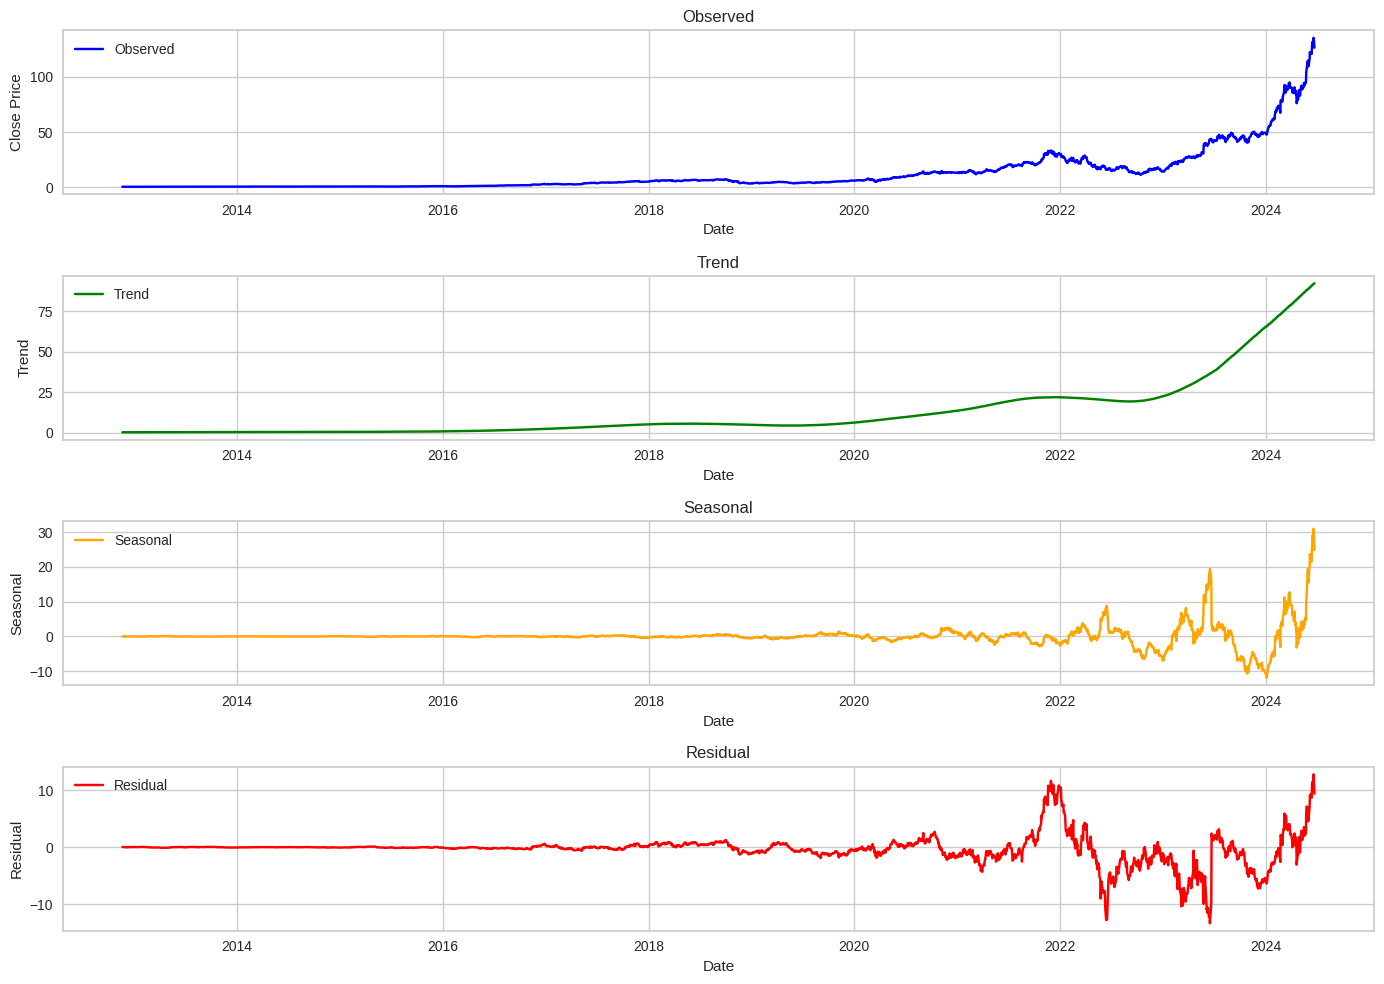

In [ ]:
# Plot the components
plt.figure(figsize=(14, 10))

plt.subplot(411)
plt.plot(components_df['Date'], components_df['Adj Close'], label='Observed', color='blue')
plt.title('Observed')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(components_df['Date'], components_df['Trend'], label='Trend', color='green')
plt.title('Trend')
plt.xlabel('Date')
plt.ylabel('Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(components_df['Date'], components_df['Seasonal'], label='Seasonal', color='orange')
plt.title('Seasonal')
plt.xlabel('Date')
plt.ylabel('Seasonal')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(components_df['Date'], components_df['Residual'], label='Residual', color='red')
plt.title('Residual')
plt.xlabel('Date')
plt.ylabel('Residual')
plt.legend(loc='best')

plt.tight_layout()
plt.show()

In [ ]:
print(nvidia_data.index)

DatetimeIndex(['2012-11-20', '2012-11-21', '2012-11-23', '2012-11-26',
               '2012-11-27', '2012-11-28', '2012-11-29', '2012-11-30',
               '2012-12-03', '2012-12-04',
               ...
               '2024-06-07', '2024-06-10', '2024-06-11', '2024-06-12',
               '2024-06-13', '2024-06-14', '2024-06-17', '2024-06-18',
               '2024-06-20', '2024-06-21'],
              dtype='datetime64[ns]', name='Date', length=2915, freq=None)


In [ ]:
# Load your NVIDIA stock data
nvidia_data_exp = data

# Verify index and columns
print(nvidia_data_exp.index)  # This should print the DateTime index

# Ensure only 'Close' column is included for forecasting
nvidia_data_exp = nvidia_data_exp[['Adj Close']]

RangeIndex(start=0, stop=2915, step=1)


In [ ]:
nvidia_data_exp

,Adj Close
0,0.265173
1,0.272789
2,0.274636
3,0.279482
4,0.280636
...,...
2910,131.880005
2911,130.979996
2912,135.580002
2913,130.779999


## TSForecastingExperiment

In [ ]:
# Initialize TSForecastingExperiment
exp = TSForecastingExperiment()

# Setup Experiment with cleaned_data
exp.setup(data=nvidia_data_exp, session_id=123, fh=100, fold=10)

# Compare Models, Create Model, Finalize Model, and Forecasting steps as before


,Description,Value
0,session_id,123
1,Target,Adj Close
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(2915, 1)"
5,Transformed data shape,"(2915, 1)"
6,Transformed train set shape,"(2815, 1)"
7,Transformed test set shape,"(100, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


In [ ]:
exp.plot_model()

In [ ]:
exp.plot_model(plot="acf")

In [ ]:
exp.plot_model(
    plot="pacf",
    data_kwargs={'nlags':30},
    fig_kwargs={'fig_size': [800, 500], 'template': 'simple_white'}
)

In [ ]:
exp.plot_model(plot="periodogram")

In [ ]:
exp.plot_model(plot="fft")

In [ ]:
exp.plot_model(plot="diagnostics", fig_kwargs={"height": 800, "width": 1000})

In [ ]:
exp.check_stats()

,Test,Test Name,Data,Property,Setting,Value
0,Summary,Statistics,Transformed,Length,,2915.0
1,Summary,Statistics,Transformed,# Missing Values,,0.0
2,Summary,Statistics,Transformed,Mean,,12.184745
3,Summary,Statistics,Transformed,Median,,4.698981
4,Summary,Statistics,Transformed,Standard Deviation,,19.338275
5,Summary,Statistics,Transformed,Variance,,373.96889
6,Summary,Statistics,Transformed,Kurtosis,,10.32273
7,Summary,Statistics,Transformed,Skewness,,2.95705
8,Summary,Statistics,Transformed,# Distinct Values,,2767.0
9,White Noise,Ljung-Box,Transformed,Test Statictic,"{'alpha': 0.05, 'K': 24}",59214.83499


In [ ]:
result_adf = adfuller(nvidia_data_exp['Adj Close'], autolag='AIC')
print(f'ADF Statistic: {result_adf[0]}')
print(f'p-value: {result_adf[1]}')

for key, value in result_adf[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: 5.872962520786018
p-value: 1.0
Critial Values:
   1%, -3.432617102137327
Critial Values:
   5%, -2.8625416527115592
Critial Values:
   10%, -2.567303208514837


In [ ]:
# KPSS Test
result_kpss = kpss(nvidia_data_exp['Adj Close'], regression = 'c')
print('\nKPSS Statistic: %f' % result_kpss[0])
print('p-value: %f' % result_kpss[1])
for key, value in result_kpss[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')


KPSS Statistic: 5.136647
p-value: 0.010000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


In [ ]:
# If p-value > 0.05, data is non-stationary and needs differencing
if result_adf[1] > 0.05:
    nvidia_data_exp['Adj Close'] = nvidia_data_exp['Adj Close'].diff().dropna()
    # Re-check for stationarity after differencing
    result_diff = adfuller(nvidia_data_exp['Adj Close'].dropna())
    print(f'ADF Statistic (Differenced): {result_diff[0]}')
    print(f'p-value (Differenced): {result_diff[1]}')

else:
    nvidia_data_exp['Adj Close'] = nvidia_data_exp['Adj Close']

ADF Statistic (Differenced): -7.422028118114994
p-value (Differenced): 6.697358460921381e-11


In [ ]:
# Plot the differenced series
plt.figure(figsize=(12, 6))
plt.plot(nvidia_data_exp['Adj Close'], label='Differenced Close Price')
plt.title('Differenced NVIDIA Stock Price Time Series')
plt.xlabel('Date')
plt.ylabel('Differenced Close Price')
plt.legend()
plt.show()

In [ ]:
nvidia_data_exp

,Adj Close
0,NaN
1,0.007616
2,0.001847
3,0.004846
4,0.001154
...,...
2910,2.270004
2911,-0.900009
2912,4.600006
2913,-4.800003


In [ ]:
nvidia_data_exp['Adj Close'] = nvidia_data_exp['Adj Close'].dropna()

In [ ]:
# Initialize the experiment
exp3 = TSForecastingExperiment()

# Setup the experiment with the differenced data
exp3.setup(data=nvidia_data_exp['Adj Close'].dropna(), session_id=123, fh=100, fold=10)


,Description,Value
0,session_id,123
1,Target,Adj Close
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(2914, 1)"
5,Transformed data shape,"(2914, 1)"
6,Transformed train set shape,"(2814, 1)"
7,Transformed test set shape,"(100, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


In [ ]:
exp3.check_stats()

,Test,Test Name,Data,Property,Setting,Value
0,Summary,Statistics,Transformed,Length,,2914.0
1,Summary,Statistics,Transformed,# Missing Values,,0.0
2,Summary,Statistics,Transformed,Mean,,0.043344
3,Summary,Statistics,Transformed,Median,,0.001676
4,Summary,Statistics,Transformed,Standard Deviation,,0.714977
5,Summary,Statistics,Transformed,Variance,,0.511191
6,Summary,Statistics,Transformed,Kurtosis,,53.702732
7,Summary,Statistics,Transformed,Skewness,,2.981067
8,Summary,Statistics,Transformed,# Distinct Values,,2787.0
9,White Noise,Ljung-Box,Transformed,Test Statictic,"{'alpha': 0.05, 'K': 24}",302.40245


In [ ]:
exp3.plot_model(plot="diagnostics", fig_kwargs={"height": 800, "width": 1000})

In [ ]:
models_to_compare = ['arima', 'ets']

# Compare selected models
best_model = exp3.compare_models(include=models_to_compare)


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,01:39:20
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,ARIMA


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)


Processing:   0%|          | 0/13 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
print(nvidia_data_exp.isna().sum())

Adj Close    1
dtype: int64


In [ ]:
nvidia_data_exp = nvidia_data_exp.dropna()

In [ ]:
test_arima = auto_arima(nvidia_data_exp['Adj Close'])
print(test_arima.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2914
Model:               SARIMAX(2, 1, 1)   Log Likelihood               -3123.571
Date:                Wed, 26 Jun 2024   AIC                           6255.142
Time:                        01:41:21   BIC                           6279.050
Sample:                             0   HQIC                          6263.755
                               - 2914                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0088      0.007     -1.316      0.188      -0.022       0.004
ar.L2         -0.0966      0.005    -21.211      0.000      -0.105      -0.088
ma.L1         -0.9848      0.001   -843.029      0.0

In [ ]:
import pandas as pd
import pmdarima as pm


# Select the column you want to model
y = nvidia_data_exp['Adj Close']

# Fit auto_arima model (non-seasonal)
model_arima = pm.auto_arima(y,
                            start_p=1, start_q=1,
                            max_p=3, max_q=3,
                            seasonal=False,
                            trace=True,
                            error_action='ignore',
                            suppress_warnings=True,
                            stepwise=True)

# Summary of the non-seasonal model
print("ARIMA model summary:")
print(model_arima.summary())

# Fit auto_arima model (seasonal)
model_sarima = pm.auto_arima(y,
                             start_p=1, start_q=1,
                             max_p=3, max_q=3,
                             seasonal=True,
                             m=12,  # assuming monthly seasonality
                             trace=True,
                             error_action='ignore',
                             suppress_warnings=True,
                             stepwise=True)

# Summary of the seasonal model
print("SARIMA model summary:")
print(model_sarima.summary())

# Compare AIC and BIC values
aic_arima = model_arima.aic()
bic_arima = model_arima.bic()
aic_sarima = model_sarima.aic()
bic_sarima = model_sarima.bic()

print(f"ARIMA AIC: {aic_arima}, BIC: {bic_arima}")
print(f"SARIMA AIC: {aic_sarima}, BIC: {bic_sarima}")

# Suggest the best model
if aic_arima < aic_sarima and bic_arima < bic_sarima:
    print("The ARIMA model is suggested as the best model based on AIC and BIC.")
else:
    print("The SARIMA model is suggested as the best model based on AIC and BIC.")


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6278.589, Time=2.80 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8244.584, Time=0.33 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7548.601, Time=0.23 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6276.610, Time=1.51 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8242.590, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=6.17 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=6276.285, Time=0.44 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=6278.261, Time=0.66 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=6278.256, Time=1.66 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=7546.619, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=6257.332, Time=1.62 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=6262.180, Time=0.95 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=6253.323, Time=2.14 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=6

KeyboardInterrupt: 

In [ ]:
import pandas as pd
import pmdarima as pm


# Select the column you want to model
y = nvidia_data_exp['Adj Close']

# Fit auto_arima model (seasonal)
model_sarima = pm.auto_arima(y,
                             start_p=1, start_q=1,
                             max_p=3, max_q=3,
                             d=1,  # Recommended differencing order
                             D=0,  # Recommended seasonal differencing order
                             seasonal=True,
                             m=36,  # Primary seasonality
                             trace=True,
                             error_action='ignore',
                             suppress_warnings=True,
                             stepwise=True)

# Summary of the seasonal model
print("SARIMA model summary:")
print(model_sarima.summary())

aic_sarima = model_sarima.aic()
bic_sarima = model_sarima.bic()

print(f"SARIMA AIC: {aic_sarima}, BIC: {bic_sarima}")



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[36] intercept   : AIC=inf, Time=71.48 sec
 ARIMA(0,1,0)(0,0,0)[36] intercept   : AIC=8244.584, Time=0.50 sec
 ARIMA(1,1,0)(1,0,0)[36] intercept   : AIC=7509.747, Time=10.02 sec
 ARIMA(0,1,1)(0,0,1)[36] intercept   : AIC=6270.261, Time=30.61 sec
 ARIMA(0,1,0)(0,0,0)[36]             : AIC=8242.590, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[36] intercept   : AIC=6276.610, Time=2.68 sec
 ARIMA(0,1,1)(1,0,1)[36] intercept   : AIC=inf, Time=79.74 sec
 ARIMA(0,1,1)(0,0,2)[36] intercept   : AIC=inf, Time=220.78 sec


KeyboardInterrupt: 